In [1]:
from model.MultiBranchModel import MultiBranchModel
from model.LSTMModel import LSTMModel
from model.GRUModel import GRUModel 
from helpers.Trainer import Trainer
from helpers.Tester import Tester
from helpers.YoutubeDataset import YoutubeDataset
from helpers.EarlyStopping import EarlyStopping
from torch.utils.data import DataLoader
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


# Load data

In [2]:
train_data = pd.read_csv('data/train_data.csv')
val_data = pd.read_csv('data/val_data.csv')
test_data = pd.read_csv('data/test_data.csv')
train_data.head()

,ytvideoid,views,comments,likes,dislikes,timestamp
0,0,354013,2472,8037,1208,2019-04-15 11:30:00
1,0,355038,2486,8083,1220,2019-04-15 12:00:00
2,0,358091,2494,8154,1242,2019-04-15 12:30:00
3,0,361332,2516,8231,1265,2019-04-15 13:00:00
4,0,364443,2547,8304,1288,2019-04-15 13:30:00


In [3]:
feature_cols = ['views', 'comments', 'likes', 'dislikes'] 

scaler = MinMaxScaler()

scaler.fit(train_data[feature_cols])

train_scaled = train_data.copy()
train_scaled[feature_cols] = scaler.transform(train_data[feature_cols])

val_scaled = val_data.copy()
val_scaled[feature_cols] = scaler.transform(val_data[feature_cols])

test_scaled = test_data.copy()
test_scaled[feature_cols] = scaler.transform(test_data[feature_cols])

train_scaled.head()

,ytvideoid,views,comments,likes,dislikes,timestamp
0,0,0.076422,0.128276,0.035702,0.210508,2019-04-15 11:30:00
1,0,0.076646,0.129002,0.035909,0.212609,2019-04-15 12:00:00
2,0,0.077312,0.129417,0.036228,0.216462,2019-04-15 12:30:00
3,0,0.078020,0.130559,0.036575,0.220490,2019-04-15 13:00:00
4,0,0.078699,0.132168,0.036903,0.224518,2019-04-15 13:30:00


In [4]:
def create_loaders(datasets_scaled: dict[str, pd.DataFrame], 
                    feature_cols: list[str], 
                    target: str, 
                    seq_len: int, 
                    forecast_horizon: int,
                    batch_size: int) -> dict[str, DataLoader]:
    
    res: dict[str, DataLoader] = {}

    for dataset_name, dataset in datasets_scaled.items():
        yt_dataset: YoutubeDataset = YoutubeDataset(
            df=dataset,
            features=feature_cols,
            target=target,
            seq_len=seq_len,
            forecast_horizon=forecast_horizon
        )

        dataloader: DataLoader = DataLoader(
                            yt_dataset,
                            batch_size=batch_size,
                            shuffle= True if dataset_name=='train' else False,
                            drop_last=True,
                            num_workers=6
                        )
        res[dataset_name] = dataloader
        print(yt_dataset.sequences.shape, yt_dataset.targets.shape)
    return res

In [5]:
seq_len = 20
forecast_horizon = 6
batch_size = 128
feature_cols = ['comments', 'likes', 'dislikes'] 

datasets_scaled: dict[str, pd.DataFrame] = {'train': train_scaled,
                                     'val': val_scaled,
                                     'test': test_scaled}

loaders = create_loaders(datasets_scaled=datasets_scaled,
                                                        feature_cols=feature_cols,
                                                        target='views',
                                                        seq_len=seq_len,
                                                        forecast_horizon=forecast_horizon,
                                                        batch_size=batch_size)
train_loader = loaders['train']
val_loader = loaders['val']
test_loader = loaders['test']

torch.Size([697783, 20, 3]) torch.Size([697783, 6])
torch.Size([141546, 20, 3]) torch.Size([141546, 6])
torch.Size([93889, 20, 3]) torch.Size([93889, 6])


# Train

In [6]:
import torch.optim as optim
import torch.nn as nn
import torch

def train(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, model_file_path: str) -> tuple[list[float], list[float]]:

    epochs = 5000
    optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=0.0001) 
    loss_fn = nn.MSELoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f'DEVICE: {device.type}')

    early_stopping = EarlyStopping(patience = 30,
                                min_delta = 0.001,
                                verbose = True,
                                path = model_file_path)

    trainer = Trainer(
        model=model,
        optimizer=optimizer,
        loss_fn=loss_fn, 
        device=device,
        early_stopping=early_stopping
    )

    train_loss, val_loss = trainer.fit(train_loader=train_loader, val_loader=val_loader, epochs=epochs)

    return train_loss, val_loss

In [44]:
multibranch_model = MultiBranchModel(
    input_size=len(feature_cols),
    hidden_size={'lstm': 50, 'gru': 50},
    num_layers={'lstm': 1, 'gru': 1},
    dropout={'lstm': 0, 'gru': 0},
    output_size=forecast_horizon
)
multibranch_train_loss, multibranch_val_loss = train(model=multibranch_model, 
                                                     train_loader=train_loader, 
                                                     val_loader=val_loader,
                                                     model_file_path='models/multibranch_model.pt')

DEVICE: cpu
Starting training.


Epoch [1/5000] | Training Loss: 0.0268 | Validation Loss: 0.0166
Validation loss improved to 0.0166


Epoch [2/5000] | Training Loss: 0.0148 | Validation Loss: 0.0158
No improvement in validation loss [1/30]


Epoch [3/5000] | Training Loss: 0.0146 | Validation Loss: 0.0156


Epoch [4/5000] | Training Loss: 0.0145 | Validation Loss: 0.0155
Validation loss improved to 0.0155


Epoch [5/5000] | Training Loss: 0.0143 | Validation Loss: 0.0154
No improvement in validation loss [1/30]


Epoch [6/5000] | Training Loss: 0.0141 | Validation Loss: 0.0151


Epoch [7/5000] | Training Loss: 0.0139 | Validation Loss: 0.0150


Epoch [8/5000] | Training Loss: 0.0137 | Validation Loss: 0.0150


Epoch [9/5000] | Training Loss: 0.0137 | Validation Loss: 0.0150
No improvement in validation loss [5/30]


Epoch [10/5000] | Training Loss: 0.0137 | Validation Loss: 0.0150


Epoch [11/5000] | Training Loss: 0.0137 | Validation Loss: 0.0150


Epoch [12/5000] | Training Loss: 0.0137 | Validation Loss: 0.0150


Epoch [13/5000] | Training Loss: 0.0137 | Validation Loss: 0.0150


Epoch [14/5000] | Training Loss: 0.0137 | Validation Loss: 0.0150
No improvement in validation loss [10/30]


Epoch [15/5000] | Training Loss: 0.0137 | Validation Loss: 0.0149


Epoch [16/5000] | Training Loss: 0.0137 | Validation Loss: 0.0150


Epoch [17/5000] | Training Loss: 0.0136 | Validation Loss: 0.0150


Epoch [18/5000] | Training Loss: 0.0136 | Validation Loss: 0.0149


Epoch [19/5000] | Training Loss: 0.0136 | Validation Loss: 0.0150
No improvement in validation loss [15/30]


Epoch [20/5000] | Training Loss: 0.0136 | Validation Loss: 0.0150


Epoch [21/5000] | Training Loss: 0.0136 | Validation Loss: 0.0150


Epoch [22/5000] | Training Loss: 0.0136 | Validation Loss: 0.0149


Epoch [23/5000] | Training Loss: 0.0136 | Validation Loss: 0.0149


Epoch [24/5000] | Training Loss: 0.0136 | Validation Loss: 0.0150
No improvement in validation loss [20/30]


Epoch [25/5000] | Training Loss: 0.0136 | Validation Loss: 0.0150


Epoch [26/5000] | Training Loss: 0.0136 | Validation Loss: 0.0150


Epoch [27/5000] | Training Loss: 0.0136 | Validation Loss: 0.0149


Epoch [28/5000] | Training Loss: 0.0136 | Validation Loss: 0.0149


Epoch [29/5000] | Training Loss: 0.0136 | Validation Loss: 0.0150
No improvement in validation loss [25/30]


Epoch [30/5000] | Training Loss: 0.0136 | Validation Loss: 0.0150


Epoch [31/5000] | Training Loss: 0.0136 | Validation Loss: 0.0150


Epoch [32/5000] | Training Loss: 0.0136 | Validation Loss: 0.0150


Epoch [33/5000] | Training Loss: 0.0136 | Validation Loss: 0.0150


Epoch [34/5000] | Training Loss: 0.0136 | Validation Loss: 0.0150
No improvement in validation loss [30/30]
Early stopping triggered.


In [45]:
lstm_model = LSTMModel(
    input_size=len(feature_cols),
    hidden_size=50,
    num_layers=1,
    dropout=0,
    output_size=forecast_horizon
)
lstm_train_loss, lstm_val_loss = train(model=lstm_model, 
                                       train_loader=train_loader, 
                                       val_loader=val_loader,
                                       model_file_path='models/lstm_model.pt')

DEVICE: cpu
Starting training.


Epoch [1/5000] | Training Loss: 0.0303 | Validation Loss: 0.0165
Validation loss improved to 0.0165


Epoch [2/5000] | Training Loss: 0.0149 | Validation Loss: 0.0161
No improvement in validation loss [1/30]


Epoch [3/5000] | Training Loss: 0.0148 | Validation Loss: 0.0159


Epoch [4/5000] | Training Loss: 0.0147 | Validation Loss: 0.0159


Epoch [5/5000] | Training Loss: 0.0147 | Validation Loss: 0.0158


Epoch [6/5000] | Training Loss: 0.0146 | Validation Loss: 0.0158
No improvement in validation loss [5/30]


Epoch [7/5000] | Training Loss: 0.0146 | Validation Loss: 0.0157


Epoch [8/5000] | Training Loss: 0.0145 | Validation Loss: 0.0157


Epoch [9/5000] | Training Loss: 0.0145 | Validation Loss: 0.0157


Epoch [10/5000] | Training Loss: 0.0144 | Validation Loss: 0.0156


Epoch [11/5000] | Training Loss: 0.0144 | Validation Loss: 0.0155
No improvement in validation loss [10/30]


Epoch [12/5000] | Training Loss: 0.0143 | Validation Loss: 0.0154
Validation loss improved to 0.0154


Epoch [13/5000] | Training Loss: 0.0142 | Validation Loss: 0.0153
No improvement in validation loss [1/30]


Epoch [14/5000] | Training Loss: 0.0140 | Validation Loss: 0.0152


Epoch [15/5000] | Training Loss: 0.0139 | Validation Loss: 0.0152


Epoch [16/5000] | Training Loss: 0.0138 | Validation Loss: 0.0152


Epoch [17/5000] | Training Loss: 0.0137 | Validation Loss: 0.0152
No improvement in validation loss [5/30]


Epoch [18/5000] | Training Loss: 0.0137 | Validation Loss: 0.0151


Epoch [19/5000] | Training Loss: 0.0137 | Validation Loss: 0.0151


Epoch [20/5000] | Training Loss: 0.0137 | Validation Loss: 0.0151


Epoch [21/5000] | Training Loss: 0.0137 | Validation Loss: 0.0151


Epoch [22/5000] | Training Loss: 0.0137 | Validation Loss: 0.0151
No improvement in validation loss [10/30]


Epoch [23/5000] | Training Loss: 0.0137 | Validation Loss: 0.0151


Epoch [24/5000] | Training Loss: 0.0136 | Validation Loss: 0.0151


Epoch [25/5000] | Training Loss: 0.0136 | Validation Loss: 0.0151


Epoch [26/5000] | Training Loss: 0.0136 | Validation Loss: 0.0151


Epoch [27/5000] | Training Loss: 0.0136 | Validation Loss: 0.0151
No improvement in validation loss [15/30]


Epoch [28/5000] | Training Loss: 0.0136 | Validation Loss: 0.0151


Epoch [29/5000] | Training Loss: 0.0136 | Validation Loss: 0.0151


Epoch [30/5000] | Training Loss: 0.0136 | Validation Loss: 0.0151


Epoch [31/5000] | Training Loss: 0.0136 | Validation Loss: 0.0151


Epoch [32/5000] | Training Loss: 0.0136 | Validation Loss: 0.0151
No improvement in validation loss [20/30]


Epoch [33/5000] | Training Loss: 0.0136 | Validation Loss: 0.0150


Epoch [34/5000] | Training Loss: 0.0136 | Validation Loss: 0.0151


Epoch [35/5000] | Training Loss: 0.0136 | Validation Loss: 0.0151


Epoch [36/5000] | Training Loss: 0.0136 | Validation Loss: 0.0151


Epoch [37/5000] | Training Loss: 0.0136 | Validation Loss: 0.0151
No improvement in validation loss [25/30]


Epoch [38/5000] | Training Loss: 0.0136 | Validation Loss: 0.0150


Epoch [39/5000] | Training Loss: 0.0136 | Validation Loss: 0.0150


Epoch [40/5000] | Training Loss: 0.0136 | Validation Loss: 0.0150


Epoch [41/5000] | Training Loss: 0.0136 | Validation Loss: 0.0150


Epoch [42/5000] | Training Loss: 0.0136 | Validation Loss: 0.0150
No improvement in validation loss [30/30]
Early stopping triggered.


In [46]:
gru_model = GRUModel(
    input_size=len(feature_cols),
    hidden_size=50,
    num_layers=1,
    dropout=0,
    output_size=forecast_horizon
)
gru_train_loss, gru_val_loss = train(model=gru_model, 
                                     train_loader=train_loader, 
                                     val_loader=val_loader,
                                     model_file_path='models/gru_model.pt')

DEVICE: cpu
Starting training.


Epoch [1/5000] | Training Loss: 0.0333 | Validation Loss: 0.0168
Validation loss improved to 0.0168


Epoch [2/5000] | Training Loss: 0.0150 | Validation Loss: 0.0161
No improvement in validation loss [1/30]


Epoch [3/5000] | Training Loss: 0.0148 | Validation Loss: 0.0160


Epoch [4/5000] | Training Loss: 0.0147 | Validation Loss: 0.0159


Epoch [5/5000] | Training Loss: 0.0147 | Validation Loss: 0.0159


Epoch [6/5000] | Training Loss: 0.0147 | Validation Loss: 0.0159
No improvement in validation loss [5/30]


Epoch [7/5000] | Training Loss: 0.0146 | Validation Loss: 0.0159


Epoch [8/5000] | Training Loss: 0.0146 | Validation Loss: 0.0158


Epoch [9/5000] | Training Loss: 0.0146 | Validation Loss: 0.0158


Epoch [10/5000] | Training Loss: 0.0146 | Validation Loss: 0.0158


Epoch [11/5000] | Training Loss: 0.0146 | Validation Loss: 0.0158
No improvement in validation loss [10/30]


Epoch [12/5000] | Training Loss: 0.0146 | Validation Loss: 0.0158
Validation loss improved to 0.0158


Epoch [13/5000] | Training Loss: 0.0146 | Validation Loss: 0.0158
No improvement in validation loss [1/30]


Epoch [14/5000] | Training Loss: 0.0146 | Validation Loss: 0.0158


Epoch [15/5000] | Training Loss: 0.0146 | Validation Loss: 0.0157


Epoch [16/5000] | Training Loss: 0.0146 | Validation Loss: 0.0157


Epoch [17/5000] | Training Loss: 0.0145 | Validation Loss: 0.0157
No improvement in validation loss [5/30]


Epoch [18/5000] | Training Loss: 0.0145 | Validation Loss: 0.0157


Epoch [19/5000] | Training Loss: 0.0145 | Validation Loss: 0.0156


Epoch [20/5000] | Training Loss: 0.0145 | Validation Loss: 0.0156


Epoch [21/5000] | Training Loss: 0.0144 | Validation Loss: 0.0156


Epoch [22/5000] | Training Loss: 0.0144 | Validation Loss: 0.0155
No improvement in validation loss [10/30]


Epoch [23/5000] | Training Loss: 0.0143 | Validation Loss: 0.0154


Epoch [24/5000] | Training Loss: 0.0142 | Validation Loss: 0.0153


Epoch [25/5000] | Training Loss: 0.0140 | Validation Loss: 0.0152


Epoch [26/5000] | Training Loss: 0.0139 | Validation Loss: 0.0151


Epoch [27/5000] | Training Loss: 0.0138 | Validation Loss: 0.0151
No improvement in validation loss [15/30]


Epoch [28/5000] | Training Loss: 0.0138 | Validation Loss: 0.0150


Epoch [29/5000] | Training Loss: 0.0138 | Validation Loss: 0.0150


Epoch [30/5000] | Training Loss: 0.0138 | Validation Loss: 0.0150


Epoch [31/5000] | Training Loss: 0.0137 | Validation Loss: 0.0150


Epoch [32/5000] | Training Loss: 0.0137 | Validation Loss: 0.0150
No improvement in validation loss [20/30]


Epoch [33/5000] | Training Loss: 0.0137 | Validation Loss: 0.0150


Epoch [34/5000] | Training Loss: 0.0137 | Validation Loss: 0.0150


Epoch [35/5000] | Training Loss: 0.0137 | Validation Loss: 0.0150


Epoch [36/5000] | Training Loss: 0.0137 | Validation Loss: 0.0150


Epoch [37/5000] | Training Loss: 0.0137 | Validation Loss: 0.0150
No improvement in validation loss [25/30]


Epoch [38/5000] | Training Loss: 0.0137 | Validation Loss: 0.0150


Epoch [39/5000] | Training Loss: 0.0137 | Validation Loss: 0.0150


Epoch [40/5000] | Training Loss: 0.0137 | Validation Loss: 0.0150


Epoch [41/5000] | Training Loss: 0.0136 | Validation Loss: 0.0150


Epoch [42/5000] | Training Loss: 0.0136 | Validation Loss: 0.0150
No improvement in validation loss [30/30]
Early stopping triggered.


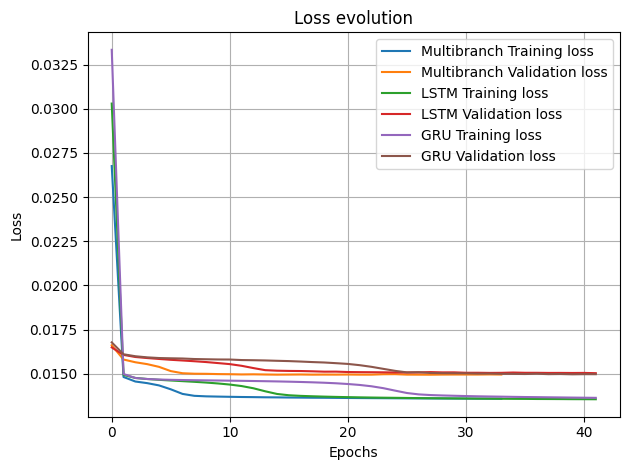

In [ ]:
plt.plot(multibranch_train_loss, label='Multibranch Training loss')
plt.plot(multibranch_val_loss, label='Multibranch Validation loss')
plt.plot(lstm_train_loss, label='LSTM Training loss')
plt.plot(lstm_val_loss, label='LSTM Validation loss')
plt.plot(gru_train_loss, label='GRU Training loss')
plt.plot(gru_val_loss, label='GRU Validation loss')
plt.title('Loss evolution')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.savefig('results/loss.png')
plt.show()


# Evaluation

In [7]:
def evaluate(model: nn.Module, model_name: str, test_loader: DataLoader) -> dict[str, float]:
    loss_fn = nn.MSELoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tester = Tester(model=model,
                    loss_fn=loss_fn,
                    device=device)
    metrics = tester.evaluate(dataloader=test_loader)
    metrics['model_name'] = model_name
    return metrics

In [8]:
multibranch_model = MultiBranchModel(
    input_size=len(feature_cols),
    hidden_size={'lstm': 50, 'gru': 50},
    num_layers={'lstm': 1, 'gru': 1},
    dropout={'lstm': 0, 'gru': 0},
    output_size=forecast_horizon
)
lstm_model = LSTMModel(
    input_size=len(feature_cols),
    hidden_size=50,
    num_layers=1,
    dropout=0,
    output_size=forecast_horizon
)
gru_model = GRUModel(
    input_size=len(feature_cols),
    hidden_size=50,
    num_layers=1,
    dropout=0,
    output_size=forecast_horizon
)
models_to_evaluate = {'multibranch_model': multibranch_model,
                      'lstm_model': lstm_model,
                      'gru_model': gru_model}

metrics_list: list[dict[str, float]] = []

for model_name, model in models_to_evaluate.items():
    model.load_state_dict(torch.load(f'models/{model_name}.pt', weights_only=False))
    metrics: dict[str, float] = evaluate(model=model, model_name=model_name, test_loader=test_loader)
    metrics_list.append(metrics)

metrics_df: pd.DataFrame = pd.DataFrame(metrics_list)
metrics_df

,loss,mse,mae,rmse,r2,model_name
0,0.013888,0.013887,0.083360,0.117845,0.591593,multibranch_model
1,0.013680,0.013680,0.082929,0.116961,0.597657,lstm_model
2,0.014068,0.014068,0.084380,0.118607,0.586290,gru_model


In [21]:
metrics_df.to_csv('results/results.csv', index=False)

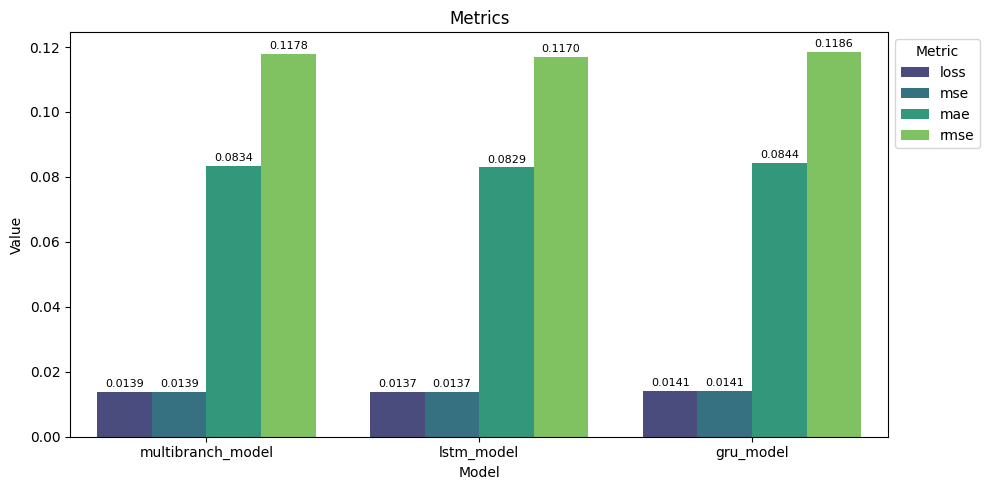

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns


metrics = ["loss", "mse", "mae", "rmse"]
df_melt = metrics_df.melt(id_vars="model_name", value_vars=metrics, var_name="metric", value_name="value")

plt.figure(figsize=(10, 5))
ax = sns.barplot(data=df_melt, x="model_name", y="value", hue="metric", palette="viridis")
for container in ax.containers:
    ax.bar_label(container, fmt="%.4f", label_type="edge", fontsize=8, padding=2)

plt.title("Metrics")
plt.ylabel("Value")
plt.xlabel("Model")
plt.legend(title="Metric", bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig('results/metrics.png')
plt.show()

